# A Simple DNN with %80 ACCURACY

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Check Submisssion Format

In [2]:
sample_df = pd.read_csv('sample_submission.csv')
print(sample_df.head())
print(sample_df.shape)

  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01        False
3     0021_01        False
4     0023_01        False
(4277, 2)


## Import Data

Also get a quick look what we are dealing by using `head()`.

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

names = train_df["Name"].str.split(" ", n = 1, expand = True)
train_df["LastName"] = names[1]

names = test_df["Name"].str.split(" ", n = 1, expand = True)
test_df["LastName"] = names[1]

print(train_df.head())
print(test_df.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported     LastName  
0        False    Ofracculy  
1         True        Vines  
2        False

## Create a Simple One-Hot Encoder
It is best to have one-hot encoding before feed into our model. It also helps get rid of `nan` values by writing 0 to all categories.

In [4]:
def myOneHotEncoder(df,df_columns,verbose=False):
    for column in df_columns:
        labels = df[column].unique()
        labels = [x for x in labels if str(x) != 'nan']
        print(labels)
        for label in labels:
            df[label] = df[column].apply(lambda x : 1.0 if x ==label else 0.0)
    if verbose:
        print(df.head())

def myLabeledOneHotEncoder(df,df_columns, labels, verbose=False):
    for column in df_columns:
        labels = [x for x in labels if str(x) != 'nan']
        print(labels)
        for label in labels:
            df[label] = df[column].apply(lambda x : 1.0 if x ==label else 0.0)
    if verbose:
        print(df.head())

## Create a Method for Filling Nan Values
It is for filling numeric values. It fills nan values with either the `mean` or the `median` value.

In [5]:
def fillNaValues(df,column,fillType):
    if fillType=="median":
        averageAge = df[column].median()
    elif fillType=="mean":
        averageAge = df[column].mean()
    else:
        averageAge = df[column].median()
    print(fillType +" is "+str(averageAge))
    df[column] = df[column].fillna(averageAge)
    if df[column].isna().sum()==0:
        print("Succesfully Filled!")

## Create Method for All Preprocessings
It is good to create a method because we will do all preprocessing to test data as well.

In [6]:
def PreprocessData(my_df,dropList, do_shuffle=False):
    df = my_df.copy()
    # Fill na values of true falses and turn them in to floats
    df["CryoSleep"] = df["CryoSleep"].fillna(0.5)
    df["CryoSleep"] = df["CryoSleep"].astype(float)

    df["VIP"] = df["VIP"].fillna(0.5)
    df["VIP"] = df["VIP"].astype(float)
    
    if "Transported" in df.columns:
        df["Transported"] = df["Transported"].astype('float32')
    
    fillNaValues(df,"RoomService","mean")
    fillNaValues(df,"FoodCourt","mean")
    fillNaValues(df,"ShoppingMall","mean")
    fillNaValues(df,"Spa","mean")
    fillNaValues(df,"VRDeck","mean")
    fillNaValues(df,"Age","mean")
    
    # Split Cabin information and deal with nans
    df["Deck"] = df["Cabin"].str.split("/").str[0]
    df["Num"] = df["Cabin"].str.split("/").str[1]
    df["Side"] = df["Cabin"].str.split("/").str[2]

    df["Num"].replace(np.nan, 0,inplace=True)
    df["Num"] = df["Num"].astype(int)
    df["Num"].replace(0, np.nan,inplace=True)
    
    fillNaValues(df,"Num","mean")
    
    myOneHotEncoder(df,["HomePlanet","Destination","Deck","Side"])
    df['TotalSpent'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    
    ## Name
    ##myLabeledOneHotEncoder(df,['LastName'],train_df["LastName"].unique(),False)
    ## Name End
    
    if do_shuffle:
        df = df.sample(frac = 1)
    
    dropped_df = pd.DataFrame()
    dropped_df[dropList] = df[dropList]
    df = df.drop(columns = dropList)
    df = df.drop(columns = ['LastName'])
    df = df.astype('float32')
    
    df.head()
    return df, dropped_df

In [7]:
new = train_df["Name"].str.split(" ", n = 1, expand = True)
#train_df["FirstName"] = new[0]
train_df["LastName"] = new[1]
train_df["LastName"].unique().shape

(2218,)

- Preprocess all data
- Put test and train data into same column order

In [8]:
train_x, dropped_df = PreprocessData(train_df,["Name","PassengerId","HomePlanet","Destination","Deck","Side","Transported","Cabin"],True)
test_x, _ = PreprocessData(test_df,["Name","PassengerId","HomePlanet","Destination","Deck","Side","Cabin"])

train_y = dropped_df["Transported"]

# Same Column Order
cols = list(train_x.columns.values)
test_x = test_x[cols]
for i in range(len(cols)):
    print(cols[i],test_x.columns.values[i])

# Check Data
print(train_x.info())
#train_x.head()
#dropped_df.head()

mean is 224.687617481203
Succesfully Filled!
mean is 458.07720329024676
Succesfully Filled!
mean is 173.72916912197996
Succesfully Filled!
mean is 311.1387779083431
Succesfully Filled!
mean is 304.8547912992357
Succesfully Filled!
mean is 28.82793046746535
Succesfully Filled!
mean is 601.6426380368098
Succesfully Filled!
['Europa', 'Earth', 'Mars']
['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e']
['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']
['P', 'S']
mean is 219.26626936829558
Succesfully Filled!
mean is 439.4842963318149
Succesfully Filled!
mean is 177.29552524527398
Succesfully Filled!
mean is 303.05244252873564
Succesfully Filled!
mean is 310.71003097450557
Succesfully Filled!
mean is 28.65814620162446
Succesfully Filled!
mean is 611.2031175059952
Succesfully Filled!
['Earth', 'Europa', 'Mars']
['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']
['G', 'F', 'C', 'B', 'D', 'E', 'A', 'T']
['S', 'P']
CryoSleep CryoSleep
Age Age
VIP VIP
RoomService RoomService
FoodCourt FoodCourt
ShoppingMall Sh

In [9]:
train_x

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,Europa,...,F,A,G,E,D,C,T,P,S,TotalSpent
409,0.0,22.0,0.0,9.0,0.000000,795.0,0.000000,0.000000,81.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,804.000000
4526,0.0,20.0,0.0,30.0,4.000000,0.0,321.000000,451.000000,601.642639,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.000000
6519,0.0,26.0,0.0,0.0,0.000000,1.0,0.000000,398.000000,1120.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,399.000000
1811,0.0,45.0,0.0,10.0,0.000000,0.0,311.138763,0.000000,118.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,321.138763
2976,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,510.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,1.0,22.0,0.0,0.0,458.077209,0.0,0.000000,0.000000,507.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,458.077209
2277,0.0,33.0,0.0,0.0,0.000000,661.0,0.000000,94.000000,507.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,755.000000
5951,0.0,7.0,0.0,0.0,0.000000,0.0,0.000000,304.854797,1023.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,304.854797
5353,0.0,70.0,0.0,390.0,0.000000,0.0,0.000000,518.000000,918.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,908.000000


## Define Custom Normalization Method
Normalization is important before feeding data into our machine

In [10]:
def normalize(df,minVals,maxVals):
    result = df.copy()
    for feature_name in df.columns:
        max_value = maxVals[feature_name]
        min_value = minVals[feature_name]
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [11]:
train_x_normalized = normalize(train_x,train_x.min(),train_x.max())
test_x_normalized = normalize(test_x,train_x.min(),train_x.max())
test_x_normalized.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,Europa,...,F,A,G,E,D,C,T,P,S,TotalSpent
0,1.0,0.341772,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001057,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
1,0.0,0.240506,0.0,0.000000,0.000302,0.00000,0.125982,0.000000,0.001585,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.078695
2,1.0,0.392405,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.322347,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
3,0.0,0.481013,0.0,0.000000,0.223124,0.00000,0.008077,0.024241,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.206130
4,0.0,0.253165,0.0,0.000698,0.000000,0.02703,0.000000,0.000000,0.002113,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.017923


In [12]:
test_x_normalized['A'].nunique()

2

## Create a Method for Spliting Data into Train and Validation
Validation is a must to test neural network performance and see if there is overfitting

In [13]:
def SplitData(df_x,df_y,split_ratio):
    split_size = int(df_x.shape[0] * split_ratio)
    train_x = df_x.iloc[:split_size]
    val_x = df_x.iloc[split_size:]
    
    train_y = df_y.iloc[:split_size]
    val_y = df_y.iloc[split_size:]
    
    return train_x, train_y, val_x, val_y

## Model

Create Model
-  Use [`L2 Regularization`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2) and `Dropout layers` to overcome overfitting
- Define [`Adam`](https://keras.io/api/optimizers/adam/) Optimizer, it will be a good choice for our binary classification. Also [`RMSprop`](https://keras.io/api/optimizers/rmsprop/) and [`SGD`](https://keras.io/api/optimizers/sgd/) can be a good option too.
- Train the network and  give **epoch number** the largest value where the accuracy rate of the validation and training sets are in the same direction (increasing).
- Select the batch size due to zig-zags in the training accuracy and loss graphs. If the much zig-zag you should increase `BATCH_SIZE`

In [14]:
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 1000
SPLIT_SIZE = 0.8
t_x, t_y, v_x, v_y = SplitData(train_x_normalized,train_y,SPLIT_SIZE)

tf.convert_to_tensor(t_x)
tf.convert_to_tensor(v_x)

# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(t_x)

model = tf.keras.Sequential([
#     normalizer,
    tf.keras.layers.Dense(2048, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

history = model.fit(t_x, t_y, epochs=120, batch_size=BATCH_SIZE,validation_data=(v_x,v_y), verbose=1)

print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])

Epoch 1/120
7/7 [==============================] - 1s 73ms/step - loss: 1.8345 - accuracy: 0.6730 - val_loss: 1.5527 - val_accuracy: 0.7217
Epoch 2/120
7/7 [==============================] - 0s 50ms/step - loss: 1.3806 - accuracy: 0.7307 - val_loss: 1.1932 - val_accuracy: 0.7257
Epoch 3/120
7/7 [==============================] - 0s 49ms/step - loss: 1.0669 - accuracy: 0.7381 - val_loss: 0.9439 - val_accuracy: 0.7343
Epoch 4/120
7/7 [==============================] - 0s 50ms/step - loss: 0.8580 - accuracy: 0.7476 - val_loss: 0.7807 - val_accuracy: 0.7447
Epoch 5/120
7/7 [==============================] - 0s 51ms/step - loss: 0.7228 - accuracy: 0.7525 - val_loss: 0.6788 - val_accuracy: 0.7550
Epoch 6/120
7/7 [==============================] - 0s 51ms/step - loss: 0.6430 - accuracy: 0.7517 - val_loss: 0.6167 - val_accuracy: 0.7545
Epoch 7/120
7/7 [==============================] - 0s 51ms/step - loss: 0.5932 - accuracy: 0.7629 - val_loss: 0.5826 - val_accuracy: 0.7642
Epoch 8/120
7/7 [===

7/7 [==============================] - 0s 52ms/step - loss: 0.4516 - accuracy: 0.8020 - val_loss: 0.4628 - val_accuracy: 0.7959
Epoch 60/120
7/7 [==============================] - 0s 54ms/step - loss: 0.4564 - accuracy: 0.7954 - val_loss: 0.4603 - val_accuracy: 0.8085
Epoch 61/120
7/7 [==============================] - 0s 51ms/step - loss: 0.4464 - accuracy: 0.8036 - val_loss: 0.4535 - val_accuracy: 0.8074
Epoch 62/120
7/7 [==============================] - 0s 49ms/step - loss: 0.4523 - accuracy: 0.7970 - val_loss: 0.4641 - val_accuracy: 0.7982
Epoch 63/120
7/7 [==============================] - 0s 50ms/step - loss: 0.4466 - accuracy: 0.8063 - val_loss: 0.4559 - val_accuracy: 0.8074
Epoch 64/120
7/7 [==============================] - 0s 50ms/step - loss: 0.4434 - accuracy: 0.8069 - val_loss: 0.4516 - val_accuracy: 0.8102
Epoch 65/120
7/7 [==============================] - 0s 49ms/step - loss: 0.4449 - accuracy: 0.8027 - val_loss: 0.4503 - val_accuracy: 0.8062
Epoch 66/120
7/7 [========

7/7 [==============================] - 0s 53ms/step - loss: 0.4283 - accuracy: 0.8096 - val_loss: 0.4504 - val_accuracy: 0.8125
Epoch 118/120
7/7 [==============================] - 0s 53ms/step - loss: 0.4263 - accuracy: 0.8102 - val_loss: 0.4420 - val_accuracy: 0.8091
Epoch 119/120
7/7 [==============================] - 0s 51ms/step - loss: 0.4252 - accuracy: 0.8174 - val_loss: 0.4435 - val_accuracy: 0.8051
Epoch 120/120
7/7 [==============================] - 0s 50ms/step - loss: 0.4295 - accuracy: 0.8095 - val_loss: 0.4432 - val_accuracy: 0.8091
0.8094621896743774
0.8090856671333313


## Plot History

We need to analyze train and validation accuracy/loss to see the real performance of the network. We are expecting train and validation accuracies to be close to each other for non-overfitting. Also, we are expecting at least %75 accuracy to have meaningful results

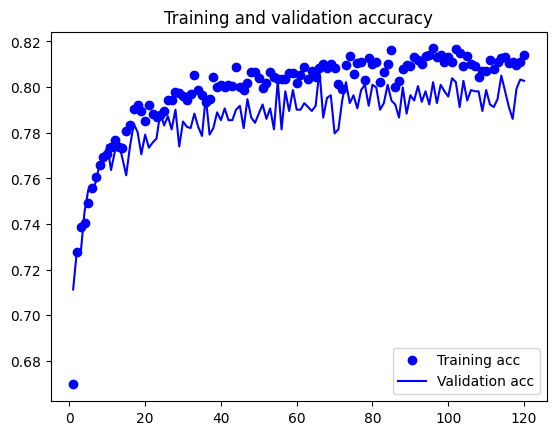

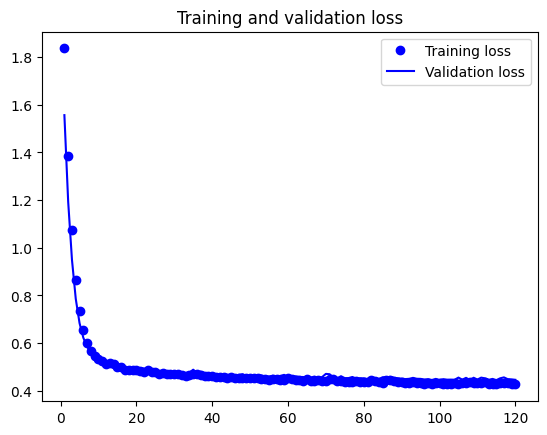

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Export Data

In [17]:
test_tensor = test_x_normalized.copy()
tf.convert_to_tensor(test_tensor)
result = model.predict(test_tensor)
print(result[:5])
# Create submission dataframe
submission_df = pd.DataFrame()
submission_df['PassengerId'] = sample_df['PassengerId']
submission_df['Transported'] = result
submission_df['Transported'] = submission_df['Transported'].apply(lambda x: True if x>=0.5 else False)
print(submission_df.head())

submission_df.to_csv('submission_DNN6.csv',index=False)

[[0.41982138]
 [0.03023982]
 [0.9985461 ]
 [0.9945551 ]
 [0.41807693]]
  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False


In [15]:
submission_df = pd.DataFrame()
submission_df = train_x

In [17]:
submission_df.to_csv('try.csv',index=False)